Helper for later to display things nicely

In [1]:
%reload_ext hamilton.plugins.jupyter_magic

from hamilton import graph_types


def custom_style(
    *, node: graph_types.HamiltonNode, node_class: str
) -> tuple[dict[str, str], str, str]:
    """Creating display style for abstract nodes."""
    if node.tags.get("node_type") == "abstract":
        style = ({"fillcolor": "blue"}, node_class, "ABC Node")

    elif node.tags.get("module") in ["prepro", "hello_world"]:
        style = ({"fillcolor": "green"}, node_class, "user input")

    else:
        style = ({"fillcolor": "orange"}, node_class, "template")

    return style

# Workflow starts here

At the moment this is based on tags and a customized Builder to get the point across.

We start of by having a pre-defined pipeline that can be comprised from a mixture of different "node type".

LEGEND:
- Orange: is template that already has a default implementation.
- Blue: abstract placeholder nodes that need to be defined.
- Green: user nodes that have been defined and are not in the template or overwrote template nodes.

For example:
1. Some complex SQL / Data Loading is already implemented through nodes `some_SQL_query`, `raw_data`
2. The pre-processing step is left as a placeholder node `preprocess` since it can be very dynamic in nature, so this postpones implementation details.
3. We then create a interface node `initial_df`, which can be thought of as an API node. In this case it serves to save the intermediate results to an external DB.
4. We then have a pretty big gap where all the business logic is left to the user. He can do basicallt whatever he wants as long as he produces at the end three API nodes: `final_df`, `signup_metrics`, `spending_metrics`.
5. We again use `final_df` to save the results. In addition, `signup_metrics`, `spending_metrics` serve as nodes that directly feed into an automated dashboard display.

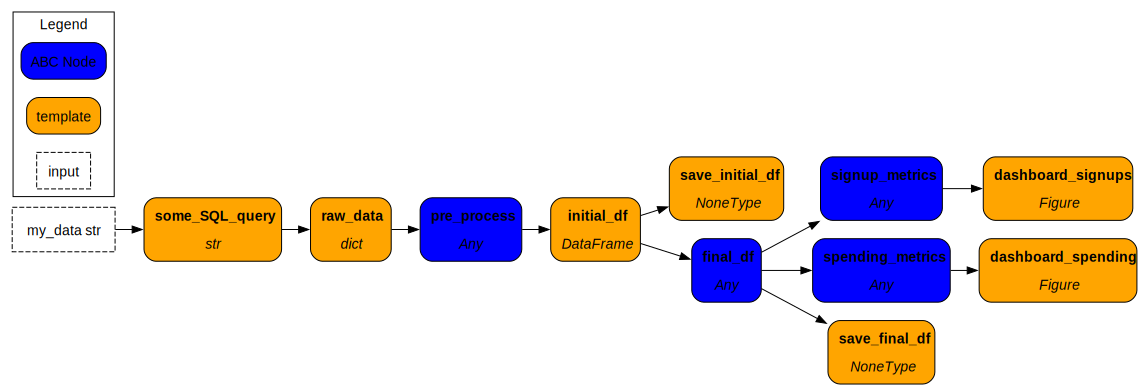

In [2]:
import pipeline_template

from abp import abstract_base_driver

my_builder = abstract_base_driver.AbcBuilder().with_modules(pipeline_template)
my_builder.visualize()

# This would be the starting point for DS.

The only focus is on data manipulation without the hassle of dealing with data loading, saving, etc...

Of course if something else is necessary, the implementer can override default behavior -- maybe good feature here is to have `prohibited nodes` that cannot be overridden.

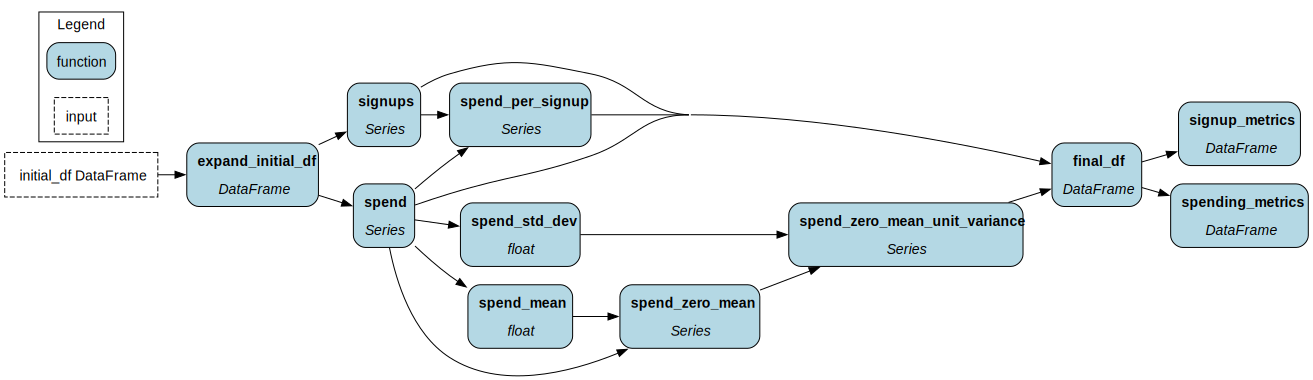

In [3]:
%%cell_to_module hello_world -d
import pandas as pd
from hamilton.function_modifiers import extract_columns
import pipeline_template

@extract_columns("spend", "signups")
def expand_initial_df(initial_df:pd.DataFrame)->pd.DataFrame:
    return initial_df

def spend_per_signup(spend: pd.Series, signups: pd.Series) -> pd.Series:
    """The cost per signup in relation to spend."""
    return spend / signups


def spend_mean(spend: pd.Series) -> float:
    """Shows function creating a scalar. In this case it computes the mean of the entire column."""
    return spend.mean()


def spend_zero_mean(spend: pd.Series, spend_mean: float) -> pd.Series:
    """Shows function that takes a scalar. In this case to zero mean spend."""
    return spend - spend_mean


def spend_std_dev(spend: pd.Series) -> float:
    """Function that computes the standard deviation of the spend column."""
    return spend.std()


def spend_zero_mean_unit_variance(
    spend_zero_mean: pd.Series, spend_std_dev: float
) -> pd.Series:
    """Function showing one way to make spend have zero mean and unit variance."""
    return spend_zero_mean / spend_std_dev


def final_df(spend:pd.Series, signups:pd.Series, spend_zero_mean_unit_variance:pd.Series, spend_per_signup:pd.Series)->pd.DataFrame:
    return pd.DataFrame(
        {"spend": spend,
        "signups": signups,
        "spend_zero_mean_unit_variance": spend_zero_mean_unit_variance,
        "spend_per_signup":spend_per_signup}
    )

def signup_metrics(final_df:pd.DataFrame)->pd.DataFrame:
    return pd.DataFrame({"signups" : final_df["signups"], "spend_zero_mean_unit_variance":final_df["spend_zero_mean_unit_variance"]})

def spending_metrics(final_df:pd.DataFrame)->pd.DataFrame:
    return pd.DataFrame({"spend" : final_df["spend"], "spend_per_signup":final_df["spend_per_signup"]})



# We thought we did everything and try to run the DAG, but it blocks us because we neglected to implement a node

In [4]:
import hello_world

dr = my_builder.with_modules(hello_world).allow_module_overrides().build()

NodeTypeError: Cannot initialise DAG with abstract nodes. Please implement the following: [Node("pre_process": Any)]

## We can go back to do it in the same module or make it a separate module

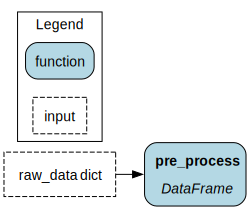

In [5]:
%%cell_to_module prepro -d

from typing import Any
import pandas as pd

def pre_process(raw_data: dict) -> pd.DataFrame:
    return pd.DataFrame(raw_data).dropna()

# Lets try again creating the DAG

We now see the full implementation and color coding shows us what has been implemented / overridden and what is template.

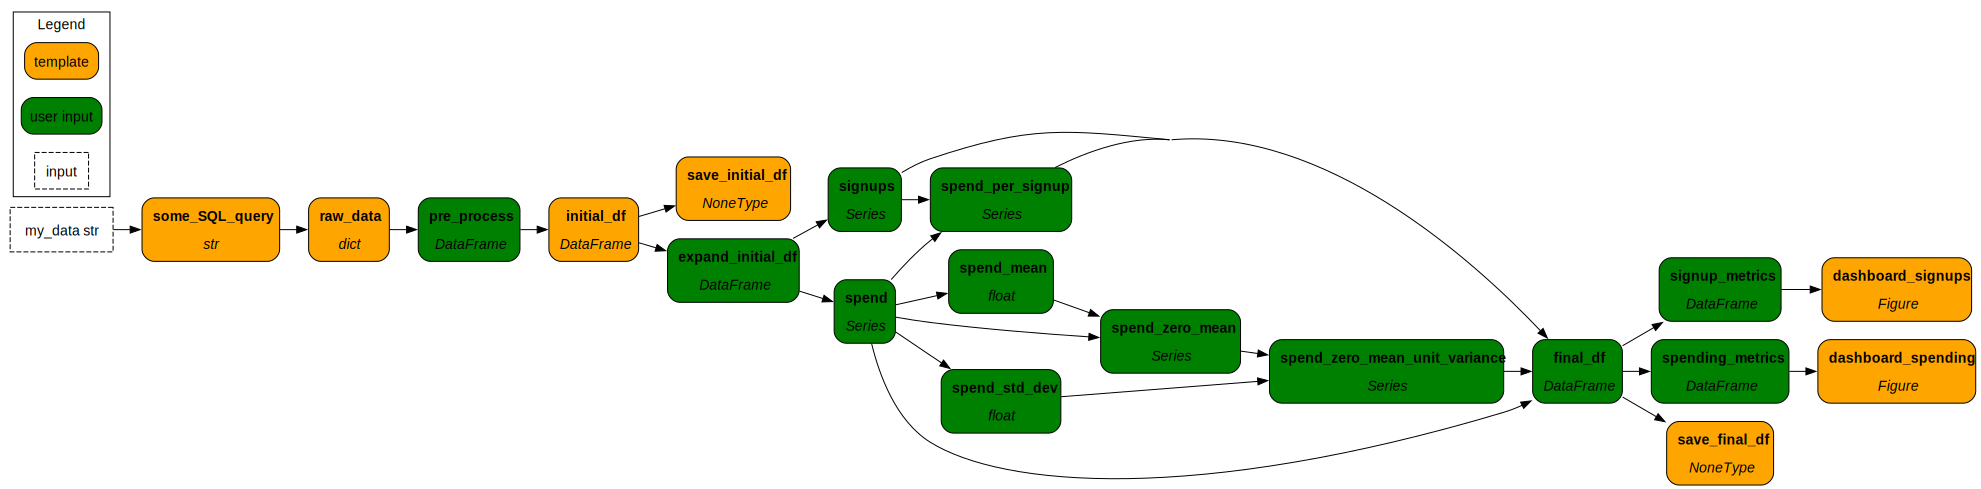

In [6]:
import prepro

dr = my_builder.with_modules(hello_world, prepro).allow_module_overrides().build()
dr.display_all_functions(custom_style_function=custom_style)

# Executing to show it works

In [7]:
output_columns = [
    "dashboard_spending",
    "dashboard_signups",
]

dashboards = dr.execute(
    final_vars=output_columns, inputs={"my_data": "spending_budget"}
)

In [8]:
dashboards["dashboard_spending"].show()

In [9]:
dashboards["dashboard_signups"].show()